In [17]:
import pandas as pd
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
import json
from datasets import Dataset, load_from_disk

In [ ]:
db = load_from_disk("/mnt/AI_NAS/datalake/staging/pending/pubtabnet_otsl_test_raw_image_38dcb082_20250616150306_kai/")

In [ ]:
import cv2
import numpy as np 
import argparse

def find_crop_boundaries(gradient_sum):
    len_thresh = 10 
    smooth =1 
    

    # 找到非空白区域的起始和结束索引
    start_indices = np.where(gradient_sum > gradient_thresh)[0]
    if len(start_indices) == 0:
        return None 

    blank_block = []
    for i in range(len(start_indices)-1):
        if start_indices[i+1] - start_indices[i]>len_thresh:
            blank_block.append([start_indices[i]+smooth,start_indices[i+1]-smooth])
    
    ## add start 
    if start_indices[0]>len_thresh:
        if start_indices[0]-smooth>0:
            blank_block = [[0,start_indices[0]-smooth]]+blank_block 
        else:
            blank_block = [[0,start_indices[0]]]+blank_block 
    
    ## add end 
    if len(gradient_sum) - start_indices[-1]>len_thresh:
        if start_indices[-1]+smooth<len(gradient_sum):
            blank_block.append([start_indices[-1]+smooth,len(gradient_sum)])
        else:
            blank_block.append([start_indices[-1],len(gradient_sum)])
    
    if len(blank_block)==0:
        return None 

    return blank_block

def crop_image(image, direction='x'):
    global h,w 
    h, w  = image.shape[:2]
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    global gradient_thresh
    gradient_thresh = 6000

    ## 计算图像的水平梯度
    gradient_x = cv2.Sobel(gray, cv2.CV_16S, 1, 0)
    gradient_y = cv2.Sobel(gray, cv2.CV_16S, 0, 1)
    gradient_x = np.abs(gradient_x)
    gradient_y = np.abs(gradient_y)
    gradient = np.maximum(gradient_x, gradient_y)
    gradient[gradient<50] = 0 
    gradient = cv2.resize(gradient, (2048,2048))

    if direction=='x':
        # 计算每一行的梯度总和
        gradient_sum = np.num(gradient,axis=1)

        # 找到上下裁剪边界
        blank_blocks = find_crop_boundaries(gradient_sum)

        # 如果找不到，则返回原始图像
        if blank_blocks is None:
            return image 
        
        # 裁剪图像
        cut_pixes = 0 
        cropped_image = image.copy()
        for blank_block in blank_blocks:
            cropped_image = np.concatenate((cropped_image[:blank_block[0]-cut_pixes,:],cropped_image[blank_block[1]-cut_pixes:,:]),0)
            cut_pixes+=blank_block[1]-blank_block[0]
        return cropped_image
    
    elif direction=='y':
        gradient_sum = np.sum(gradient, axis=0)

        blank_blocks = find_crop_boundaries(gradient_sum)

        if blank_blocks is None:
            return image 

        cut_pixes=0
        cropped_image = image.copy()
        for blank_block in blank_blocks:
            cropped_image = np.concatenate((cropped_image[:,:blank_block[0]-cut_pixes],cropped_image[:,blank_block[1]-cut_pixes:]),0)
            cut_pixes+=blank_block[1]-blank_block[0]
    
    elif direction=='xy':
        regions = np.zeros(gradient.shape)
        regions = cv2.cvtColor(regions.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    
        gradient_sum = np.sum(gradient, axis=1)
        blank_blocks = find_crop_boundaries(gradient_sum)

        scale = h/2048
        if blank_blocks is not None:
            cut_pixes=0
            cropped_image = image.copy()
            for blank_block in blank_blocks:
                cropped_image = np.concatenate((cropped_image[:int((blank_block[0]-cut_pixes)*scale),:], cropped_image[int((blank_block[1]-cut_pixes)*scale):,:]),0)
                cut_pixes+=blank_block[1]-blank_block[0]
                regions[blank_block[0]:blank_block[1],:,:] = (240,175,0)
        else:
            cropped_image = image 

        gradient_sum = np.sum(gradient, axis=0)
        blank_blocks = find_crop_boundaries(gradient_sum)
        if blank_blocks is None:
            return cropped_image, gradient, regions

        cut_pixes = 0
        cropped_image = cropped_image.copy()
        scale = w/2048
        for blank_block in blank_blocks:
            cropped_image = np.concatenate((cropped_image[:,:int((blank_block[0]-cut_pixes)*scale)],cropped_image[:,int((blank_block[1]-cut_pixes)*scale):]),1)
            cut_pixes+=blank_block[1]-blank_block[0]
            regions[:,blank_block[0]:blank_block[1],:]=(240,176,0)

        return cropped_image, gradient, regions 


In [47]:

im = cv2.imread('test3.jpeg')
h,w = im.shape[:2]
cropped_image, gradient, regions = crop_image(im,'xy')

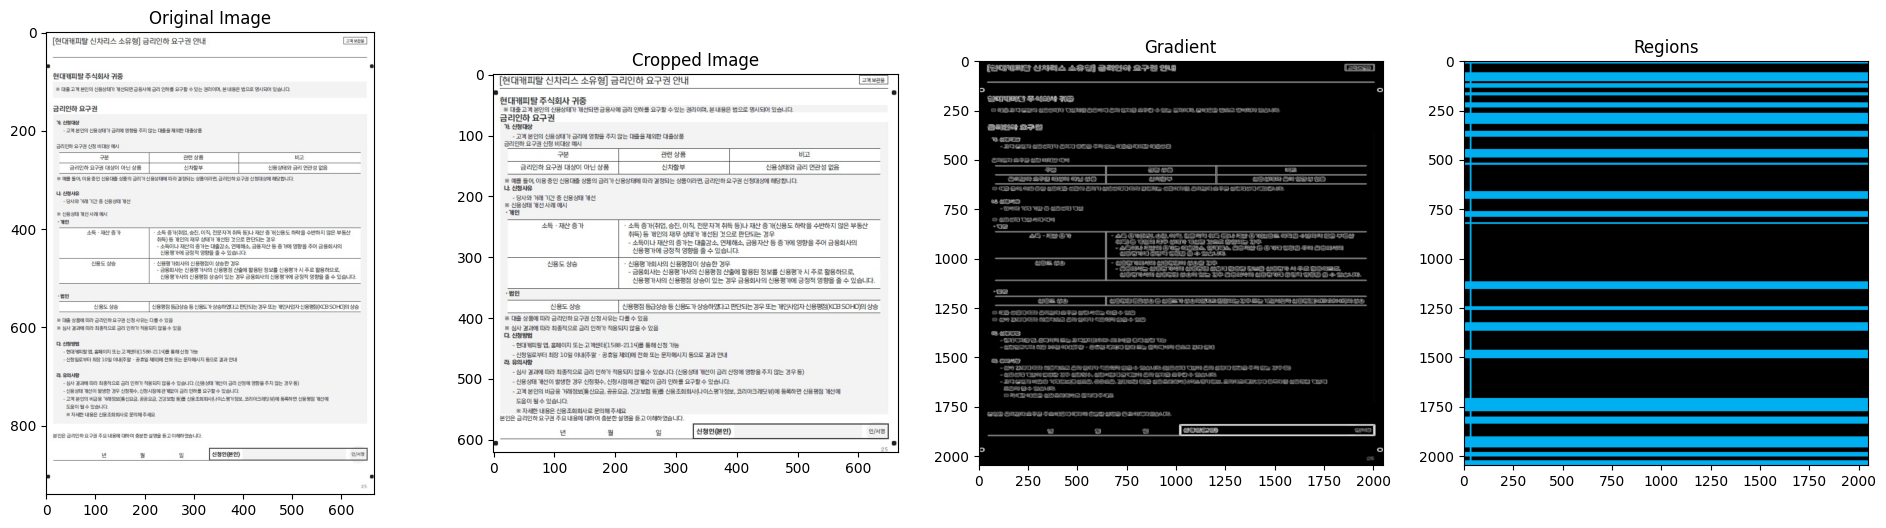

In [48]:
from matplotlib import pyplot as plt
plt.figure(figsize=(24, 6))
plt.subplot(1, 4, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.subplot(1, 4, 2)
plt.title('Cropped Image')
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 4, 3)          
plt.title('Gradient')
plt.imshow(gradient, cmap='gray')
plt.subplot(1, 4, 4)
plt.title('Regions')
plt.imshow(cv2.cvtColor(regions, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:







if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='Params')
    parser.add_argument('--im_path',type=str,default='demo/demo.jpg')
    parser.add_argument('--resize',action='store_true')
    parser.add_argument('--visualize',action='store_true')
    args = parser.parse_args()


    im = cv2.imread(args.im_path)
    h,w = im.shape[:2]
    cropped_image, gradient, regions = crop_image(im,'xy')


    if args.resize:
        new_h, new_w = cropped_image.shape[:2]
        if h>w and new_h>new_w or h<w and new_h<new_w:
            cropped_image = cv2.resize(cropped_image,(w,h))
        else:
            cropped_image = cv2.resize(cropped_image,(h,w))


    im_format = '.'+args.im_path.split('.')[-1]
    cv2.imwrite(args.im_path.replace(im_format,'_aps'+im_format),cropped_image)
    if args.visualize:
        gradient = cv2.resize(gradient,(w,h))
        regions = cv2.resize(regions,(w,h))
        regions = cv2.addWeighted(im,0.5,regions,0.5,gamma=0)
        cv2.imwrite(args.im_path.replace(im_format,'_visualize1'+im_format),gradient)
        cv2.imwrite(args.im_path.replace(im_format,'_visualize2'+im_format),regions)




In [26]:
# db['file_path']의 pubtabnet_otsl_test_raw_image_38dcb082_20250616150306_kai를 pubtabnet_otsl_val_raw_image_38dcb082_20250616150306_kai으로 변경


['pubtabnet_otsl_test_raw_image_38dcb082_20250616150306_kai/assets/batch_0000/file_000000.png',
 'pubtabnet_otsl_test_raw_image_38dcb082_20250616150306_kai/assets/batch_0000/file_000001.png',
 'pubtabnet_otsl_test_raw_image_38dcb082_20250616150306_kai/assets/batch_0000/file_000002.png',
 'pubtabnet_otsl_test_raw_image_38dcb082_20250616150306_kai/assets/batch_0000/file_000003.png',
 'pubtabnet_otsl_test_raw_image_38dcb082_20250616150306_kai/assets/batch_0000/file_000004.png',
 'pubtabnet_otsl_test_raw_image_38dcb082_20250616150306_kai/assets/batch_0000/file_000005.png',
 'pubtabnet_otsl_test_raw_image_38dcb082_20250616150306_kai/assets/batch_0000/file_000006.png',
 'pubtabnet_otsl_test_raw_image_38dcb082_20250616150306_kai/assets/batch_0000/file_000007.png',
 'pubtabnet_otsl_test_raw_image_38dcb082_20250616150306_kai/assets/batch_0000/file_000008.png',
 'pubtabnet_otsl_test_raw_image_38dcb082_20250616150306_kai/assets/batch_0000/file_000009.png',
 'pubtabnet_otsl_test_raw_image_38dcb082

In [ ]:
d['html']

In [6]:
from pyhwp import hwp5
from pyhwp.hwp5 import binmodel

hwp_file = hwp5.Hwp5File('(19-34) 품질지표기준서_자연 발화 동영상-인체 3D 포즈 데이터_v1.1(241028).hwp')

ModuleNotFoundError: No module named 'pyhwp'

In [4]:
import olefile

In [5]:
olefile.

<module 'olefile' from '/home/kai/anaconda3/envs/kaiocr/lib/python3.12/site-packages/olefile/__init__.py'>

In [ ]:
# image_path를 전부 basename + dirname으로 변경
d["image_path"] = d["image_path"].apply(lambda x: "/".join(x.split("/")[-2:]))
# images/ 제거
d["image_path"] = d["image_path"].apply(lambda x: x.replace("images/", ""))

In [ ]:
d['date'] = '2025-06-10'

In [ ]:
from datasets import Dataset

In [ ]:
ddd= Dataset.from_pandas(d)

In [ ]:
ddd.to_parquet("test2.parquet")

In [ ]:
d.to_parquet("vis_qa.parquet", index=False)

# label의 <|bbox|> 키 모두 제거 iterable로 순회하면서 제거
def remove_bbox_key(label):
    if isinstance(label, dict):
        return {k: remove_bbox_key(v) for k, v in label.items() if k != "<|bbox|>"}
    elif isinstance(label, list):
        return [remove_bbox_key(item) for item in label if item != "<|bbox|>"]
    else:
        return label

for row in tqdm(range(len(d))):
    label = d['label'][row]
    width = d['width'][row]
    height = d['height'][row]
    if isinstance(label, str):
        label = json.loads(label)
    label = remove_bbox_key(label)
    d.at[row, 'label'] = json.dumps(label, ensure_ascii=False)

In [ ]:
import duckdb

# NAS에서 직접 parquet 쿼리
conn = duckdb.connect()


In [313]:

result = conn.execute("""
    SELECT * FROM read_parquet('/mnt/AI_NAS/datalake/catalog/provider=*/dataset=*/task=*/variant=*/lang=*/src=*/mod=table/data.parquet', union_by_name=True, filename=True, hive_partitioning=True)
""").fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [314]:
result

,image_path,width,height,label,date,query,filename,dataset,lang,provider,src,task,variant
0,catalog/provider=aihub/dataset=diverse_ocr_cha...,64,80,가,2025-06-12,None,/mnt/AI_NAS/datalake/catalog/provider=aihub/da...,diverse_ocr_char,ko,aihub,real,ocr,recognition_char
1,catalog/provider=aihub/dataset=diverse_ocr_cha...,63,80,각,2025-06-12,None,/mnt/AI_NAS/datalake/catalog/provider=aihub/da...,diverse_ocr_char,ko,aihub,real,ocr,recognition_char
2,catalog/provider=aihub/dataset=diverse_ocr_cha...,81,96,간,2025-06-12,None,/mnt/AI_NAS/datalake/catalog/provider=aihub/da...,diverse_ocr_char,ko,aihub,real,ocr,recognition_char
3,catalog/provider=aihub/dataset=diverse_ocr_cha...,102,103,갇,2025-06-12,None,/mnt/AI_NAS/datalake/catalog/provider=aihub/da...,diverse_ocr_char,ko,aihub,real,ocr,recognition_char
4,catalog/provider=aihub/dataset=diverse_ocr_cha...,86,93,갈,2025-06-12,None,/mnt/AI_NAS/datalake/catalog/provider=aihub/da...,diverse_ocr_char,ko,aihub,real,ocr,recognition_char
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860769,catalog/provider=opensource/dataset=real_kie/i...,2481,3508,"{""Risk Clauses"": [{""<|value|>"": ""The investmen...",2025-06-11,None,/mnt/AI_NAS/datalake/catalog/provider=opensour...,real_kie,en,opensource,real,kie,base_kie
1860770,catalog/provider=opensource/dataset=real_kie/i...,2481,3508,"{""(Header) Dividend Policy"": [{""<|value|>"": ""P...",2025-06-11,None,/mnt/AI_NAS/datalake/catalog/provider=opensour...,real_kie,en,opensource,real,kie,base_kie
1860771,catalog/provider=opensource/dataset=real_kie/i...,2481,3508,"{""Risk Clauses"": [{""<|value|>"": ""Although the ...",2025-06-11,None,/mnt/AI_NAS/datalake/catalog/provider=opensour...,real_kie,en,opensource,real,kie,base_kie
1860772,catalog/provider=opensource/dataset=real_kie/i...,2481,3508,"{""Risk Clauses"": [{""<|value|>"": ""The Fund coul...",2025-06-11,None,/mnt/AI_NAS/datalake/catalog/provider=opensour...,real_kie,en,opensource,real,kie,base_kie


In [ ]:
import 

In [ ]:
result

In [ ]:
# result 에서 filename이 같은거 1개남기고 다 제거
header = result.drop_duplicates(subset=['filename'], keep='first')

In [ ]:
header

In [ ]:
# date 가 없는 경우 찾기
result[result['date'].isnull()]

In [ ]:
result = conn.execute("""
    SELECT * FROM '/mnt/AI_NAS/datalake/catalog/provider=*/dataset=postoffice_label/task=*/variant=base_kie/**/data.parquet'
""").fetchdf()

In [ ]:
result['label'][0]

In [ ]:
result

In [ ]:
d.to_parquet("tourism_food_menu_board.parquet", index=False)

In [ ]:

# label은 json형태로 되어있음
# text key값을 <|value|>로 바꾸고, bbox key값을 <|bbox|>로 바꾸기
def normalized_bbox(box, width, height):
    return [
        box[0] / width,  # x_min
        box[1] / height,  # y_min
        box[2] / width,  # x_max
        box[3] / height  # y_max
    ]

def wrap_value(v):
    return {"<|value|>": v}

def convert_to_value_dict(obj):
    if isinstance(obj, dict):
        return {k: convert_to_value_dict(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_value_dict(v) for v in obj]
    else:
        return wrap_value(obj)


for row in tqdm(range(len(d))):
    label = d['label'][row]
    width = d['width'][row]
    height = d['height'][row]
    if isinstance(label, str):
        label = json.loads(label)
      
    label = convert_to_value_dict(label)
    # # <|bbox|> 값을 width와 height를 이용하여 상대좌표로 변환
    # for key, value in label.items():
    #     if '<|value|>' not in value and '<|bbox|>' not in value:
    #         print(f"{key} does not contain <|value|> or <|bbox|> in row {row}")
    #         continue
    #     if '<|bbox|>' in value:
    #         bbox = value['<|bbox|>']
    #         if isinstance(bbox, list) and len(bbox) == 4:
    #             normalized = normalized_bbox(bbox, width, height)
    #             label[key]['<|bbox|>'] = normalized
    #         else:
    #             print(f"Invalid bbox format in row {row}: {bbox}")
    #             continue
    #     if '<|value|>' in value:
    #         value['<|value|>'] = re.sub(r'/s+', ' ', value['<|value|>'].replace('/n', ' ').replace('/r', ' ').replace('/t', ' ')).strip()
            
    d.at[row, 'label'] = json.dumps(label, ensure_ascii=False)

In [ ]:
d

In [ ]:
d.to_parquet("gdkh_prescriptions.parquet", index=False)

In [ ]:
label

In [ ]:
d.to_parquet("invoice_kie.parquet", index=False)

In [ ]:
df = pd.DataFrame(df, columns=["html"])

In [ ]:
df.to_parquet("tech_sci_mrc.parquet")

In [ ]:
records

In [ ]:
d

In [ ]:
test_html = d.loc[6716]['html']
soup = BeautifulSoup(test_html, "html.parser")
tables = soup.find_all("table")
results = []

In [ ]:
tables = extract_tables(d.loc[392]['html'])

In [ ]:
tables

In [ ]:
tables[3]

In [ ]:
extract_tables_with_thead(d.loc[6716]['html'])[0]